![alt text](img/LM.png)
# Kurs: Warsztaty Machine learning w Pythonie

## Prowadzący: Piotr Ćwiakowski

## Autorzy: Piotr Ćwiakowski, Maciej Wilamowski

### Lekcja 12. Boosting (algorytm  XGBoost)

#### Spis treści:
1. Wprowadzenie
2. Boosting - teoria
3. Implementacja boostingu w Pythonie
4. Przegląd hiperparametrów
5. Walidacja krzyżowa xgboost
6. Praktyczny poradnik tuningu XGB
7. Metody tuningu hiperparametrów

## 1. Wprowadzenie
Widzieliśmy już jak elastyczny, wydajny i skuteczny potrafi być algorytm Random Forest. Jedno z podstawowych założeń dotyczących tego algorytmu to niezależność poszczególnych drzew. Skutkuje to wysoką odpornością na przeuczenie modelu, ale z drugiej strony istnieje ryzyko, że algorytm nie nauczy się wszystkiego co ważne. W końcu każdy jeden klasyfikator w Random Forest jest relatywnie prosty i ograniczony.  

Boosting różni się od Random Forest przede wszystkich w dwóch obszarach. 

* Wykorzystuje zasadę boostingu. Oznacza to, że kolejne drzewa są od siebie zależne, gdyż kolejne drzewa uczą się jako cel do wyjaśnienia przyjmują to, czego nie udało się wyjaśnić poprzednim drzewom.

* W celu zwiększenia różnorodności, podobnie jak w RF losowane są kolumny, ale w ramach różnorodności obserwacji zamiast bootstrapu (losowanie ze zwracaniem) wybierana jest losowo podpróba obserwacji o określonym udziale.

Proces dodawania kolejnych drzew ilustruje poniższy przykład (źródło: http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

<img src="img/boosting1.png" width="80%">

<img src="img/boosting2.png" width="60%">

<img src="img/boosting4.png" width="60%">

<img src="img/boosting5.png" width="60%">

<img src="img/boosting6.png" width="60%">

## 2. Gradient boosting - teoria
Idea boostingu jest relatywnie prosta. Kiedy zbudujemy pierwszy model (nie musi być to drzewo decyzyjne, może to być niemalże dowolny model). To uzyskamy pierwsze predykcje $\hat{Y_1}$, które będą się różnić od prawdziwych wartości $Y$. Dzięki czemu zobaczymy jak wygląda błąd pierwszego modelu.


$$\text{Błąd pierwszego modelu} = \epsilon_1 = Y - \hat{Y_1}$$

Następnie będziemy budować kolejny model. Z tym, że celem dla drugiego modelu nie będzie już $Y$, ale to co pozostało po pierwszym modelu (pozostąły błąd pierwszego modelu - $\epsilon_1$).

$$\epsilon_2 = \epsilon_1 - \hat{Y_2}$$

Tak będziemy budować kolejne modele. W praktyce okazuje się, że przy takiej definicji model i tak zbyt szybko się przeuczy - pierwszy model wyjaśni prawie całą zmienność. Będziemy więc chcieli spowodować, by wnioski z pierwszego modelu miały mniejszą wagę. Wprowadzimy więc parametr *learning rate*, który powie jak dużą część (między 0 a 1) wniosków pierwszego modelu mamy dalej uzyć. Zwykle *learning rate* nazywany jest eta ($\eta$).

W tej sytuacji prognozy kolejnych modeli będą miały następujące "targety" do uczenia się:
$$\epsilon_1 = Y - \hat{Y_1}$$

$$\epsilon_2 = [Y - \eta * \epsilon_1] - \hat{Y_2}$$

$$\epsilon_3 = [Y - \eta * \epsilon_1  - \eta * \epsilon_2] - \hat{Y_3}$$

Jak widać każdy kolejny model będzie korzystał z wczesniej wytworzonej wiedzy, ale tylko w małym stopniu. Warto zauwazyć, że boosting możemy zastosować do dowolnego algorytmu machine learningu. W praktyce najczęściej jest stosowany do drzew decyzyjnych, ze względu na ich szybkość oraz elastyczność (w pracy ze zmiennymi kategorycznymi i nieliniowymi transformacjami zmiennych ciągłych).

Prognoza kombinowana okazuje się znacznie lepsza od pojedynczej. Możemy to zilustrować jeszcze w inny sposób:

<img src="img/boosting7.png" width="60%">

Możemy też skorzystać z doskonałych wizualizacji w Internecie:

* https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html
* http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html


Oczywiście gradient boosting jest o wiele bardziej skomplikowany, ale jego specyfikację wyjaśnimy szczegółowiej przy okazji omawiania kolejnych hiperparametrów.

Link do dokumentacji pakietu:
https://xgboost.readthedocs.io/en/stable/tutorials/model.html

## 3. Implementacja boostingu w Pythonie

In [3]:
# import pakietów
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

# Prepocessing
from sklearn import preprocessing

# import metod do walidacji krzyżowej
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Narzędzia do wrapperów xgb
from random import shuffle
from random import randint
from operator import itemgetter

%matplotlib inline

### 3.1. Wczytanie zbioru danych
Zbiór wczytamy analogicznie jak w przypadku Random Forest.

In [4]:
df_o = pd.read_csv("data/bank-balanced.csv")
print(df_o.shape)
df_o.head()

(11162, 17)


age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [5]:
df_o.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [6]:
target = "deposit"
numFeatures = ['age', 'balance', 'duration', 'campaign', 'pdays','previous', 'day']
catFeatures = [ 'job', 'marital', 'education', 'default',  'housing', 'loan', 'contact',  'month', 'poutcome']

In [7]:
df = df_o.copy()
mapy = {}
for feature in catFeatures:
    # Iniciujemy obiekt do kodowania, który będzie przechowywał naszą mapę
    le = preprocessing.LabelEncoder()
    # Dopasowujemy danę (tworzymy mapę) i od razu ją nakadamy na zmienną na której robiliśmy dopasowanie
    df[feature] = le.fit_transform(df_o[feature])

    # Zapiszmy nasza mapę, aby móc odzyskać oryginalne dane bez problemu
    mapy[feature] = le

In [8]:
features = df.columns.tolist()
features.remove(target)
print(features)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [9]:
df[target] = (df[target]=="yes").astype(int)

### 3.2. Wrapper dla XGBoost
Im bardziej złożony algorytm, tym więcej możliwości i bardziej rozbudowany wrapper. XGBoost stawia przed nami jeszcze więcej wymagań, ale daje również więcej możliwości. Przygotujemy dla niego specjalny wrapper. Nasz pierwszy wrapper będzie służył wyłącznie do uruchomienia XGBoosta z pełną konfiguracją. Walidację krzyżową dodamy w dalszym kroku.

XGBoost posiada dobrze udokumentowane API dla Pythona (http://xgboost.readthedocs.io/en/latest/python/python_api.html), które pozwala na pracę z XGB na dwa sposoby:
* opierając się o API standaryzowane dla sklearn, który zawiera osobne moduły dla regresji i klasyfikacji,
* opierając się o uniwersalny obiekt train.

Wydaje się, że elastyczniej jest posiadać dobrze skonfigurowany wrapper XGB w oparciu o uniwersalny obiekt train. Poniżej znajduje się przykład takiego wrappera, który pozwala na zastosowanie XGB dla niemalże dowolnego problemu. Odpowiednie skonsturowany wrapper umożliwia łatwe uruchomienie walidacji krzyżowej, wydobycie pełnej informacji o procesie szkolenia algorytmu oraz łatwe wpięcie w istniejący pipeline ML.

Budowanie kolejnych wersji wrappera krok po kroku byłoby zbyt czasochłonne, dlatego poniżej znajduje się względnie kompletna jego implementacja.

Wszystkie argumenty funkcji zostały rozbite na trzy grupy: 
* obowiązkowych, 
* podstawowych argumentów do tuningu hiperparametrów oraz 
* argumenty konfiguracyjne.

In [10]:
def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensemble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX=0 : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight=0 : minimalna suma wag poddrzewa

    --- Zmienne dla algorytmu dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    debug : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’ zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do zapisania historii dopasowania modelu 
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenia statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamiast słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

**Przygotowanie zbioru treningowego i walidacyjnego.** Do przygotowania zbioru treningowego i walidacyjnego wykorzystamy train_test_split z biblioteki sklearn (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Warto zwrócić uwagę na argument stratify, ktory pozwala losować warstwowo do prób. Zapewnienie odpowiedniej proporcji 1 i 0 w podzbiorach ma ogromne znaczenie, gdyż w wielu przypadkach czyste losowanie może doprowadzić do mocno niereprezentatywnych podprób, a w konsekwencji do obciążonych modeli.

In [12]:
test_size = 0.2
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2017, stratify=df[target].values)

### 3.3. Pierwszy trening
Kiedy mamy już przygotowane zbiory do treningu i walidacji możemy przystąpić do pierwszego uruchomienia treningu XGB. Wszystkie parametry będą ustawione domyślnie z wyjątkiem early_stopping_rounds, który zwiększymy do 50, aby móc przyjrzeć się temu jak model się przetrenowuje.

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 8929
Length valid: 2233
[18:55:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.90053	valid-auc:0.88253
[1]	train-auc:0.91730	valid-auc:0.89402
[2]	train-auc:0.92065	valid-auc:0.89717
[3]	train-auc:0.92725	valid-auc:0.90102
[

[178]	train-auc:0.97182	valid-auc:0.92359
[179]	train-auc:0.97194	valid-auc:0.92357
[180]	train-auc:0.97200	valid-auc:0.92360
[181]	train-auc:0.97213	valid-auc:0.92362
[182]	train-auc:0.97222	valid-auc:0.92378
[183]	train-auc:0.97236	valid-auc:0.92381
[184]	train-auc:0.97241	valid-auc:0.92379
[185]	train-auc:0.97254	valid-auc:0.92388
[186]	train-auc:0.97268	valid-auc:0.92386
[187]	train-auc:0.97276	valid-auc:0.92382
[188]	train-auc:0.97292	valid-auc:0.92383
[189]	train-auc:0.97302	valid-auc:0.92383
[190]	train-auc:0.97320	valid-auc:0.92389
[191]	train-auc:0.97334	valid-auc:0.92387
[192]	train-auc:0.97357	valid-auc:0.92416
[193]	train-auc:0.97380	valid-auc:0.92436
[194]	train-auc:0.97397	valid-auc:0.92441
[195]	train-auc:0.97403	valid-auc:0.92442
[196]	train-auc:0.97423	valid-auc:0.92457
[197]	train-auc:0.97440	valid-auc:0.92451
[198]	train-auc:0.97450	valid-auc:0.92457
[199]	train-auc:0.97457	valid-auc:0.92443
[200]	train-auc:0.97464	valid-auc:0.92449
[201]	train-auc:0.97494	valid-auc:

[374]	train-auc:0.98912	valid-auc:0.92579
[375]	train-auc:0.98914	valid-auc:0.92581
[376]	train-auc:0.98919	valid-auc:0.92578
[377]	train-auc:0.98921	valid-auc:0.92572
[378]	train-auc:0.98928	valid-auc:0.92580
[379]	train-auc:0.98931	valid-auc:0.92581
[380]	train-auc:0.98936	valid-auc:0.92580
[381]	train-auc:0.98939	valid-auc:0.92578
[382]	train-auc:0.98947	valid-auc:0.92583
[383]	train-auc:0.98951	valid-auc:0.92585
[384]	train-auc:0.98953	valid-auc:0.92586
[385]	train-auc:0.98958	valid-auc:0.92581
[386]	train-auc:0.98962	valid-auc:0.92585
[387]	train-auc:0.98966	valid-auc:0.92584


C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Czas trenowania: 0.07 minut


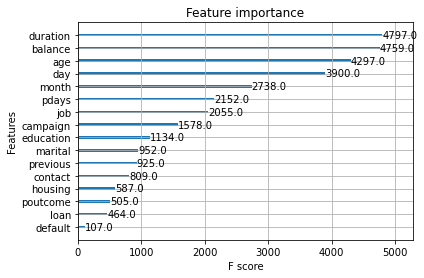

In [13]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, 
                                                                 features, target, 
                                                                 early_stopping_rounds=50)

W przypadku boostowanych drzew decyzyjnych najlepszą metodą na rozwiązanie problemu overfittingu jest zwiększenie treningowego zbioru danych. XGB jest z powodzeniem wykorzystywany na zbiorach danych zawierających setki tysięcy, a nawet miliony obserwacji. Właśnie na takich zbiorach mamy szansę zobaczyć pełnię możliwości algorytmu. Korzyści z lokalnego dopasowania nie przekładają się tak szybko na przetrenowanie modelu jako całości.

Jak widać  algorytm bez problemu "przetrenowuje się" (*overfitting*). W miejscu w którym osiągamy największą wartość AUC na zbiorze testowym - 0.925 - obserwujemy AUC dla zbioru treningowego na poziomie 0.987, co ilustruje poniższy wykres.

### 3.4. Early stoppping
Ponieważ w XGBoost kolejne drzewa wykorzystują predykcje wcześniejszych modeli widzimy, że bardzo łatwe jest przetrenowanie modelu. Z tego powodu stosujemy tzw. early stopping, czyli zatrzymywanie treningu w sytuacji, w której wynik na zbiorze testowym zaczyna się pogarszać. Jest to bardzo prosta, ale również skuteczna metoda do określenia optymalnej liczby drzew w danym modelu.

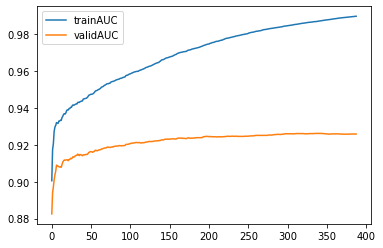

In [14]:
train_history.plot()
plt.show()

## 4. Dobór hiperparametrów
Zagadnienie dobierania hiperparametrów jest bardzo szerokie i stanowi oddzielny temat, a nawet obszar badawczy. Niemniej ze względu na to, ze kolejne drzewa są ze sobą powiązane, XGBoost jest algorytmem gdzie early stopping oraz dobór hiperparametrów stają się naprawdę istotne.

Proces ten należy przeprowadzać stosując walidację krzyżową, będąc w pełni świadomym jej ograniczeń. Aby je dokładnie zrozumieć rozpocznijmy od iteracyjnego dobierania parameterów dla XGB. Najpierw, w celu przyśpieszenia obliczeń i ułatwienie wizualizacji, na tylko jednym foldzie.

Taka procedura pozwoli nam zdobyć intuicyjne rozumienie wpływu poszczególnych parametrów na zachowanie algorytmu, a w konsekwencji zrozumieć dlaczego tak łatwo jest popełnić błąd przetrenowania szukając najlepszych hiperparametrów.

Dla XGB najważniejsze parametry to:
* `max_depth`
* `subsample`
* `colsample_bytree`
* `lambda`

### 4.1. Głębokość drzew `max_depth`
Nie ma typowej wartości dla głębokości drzew. Na niektórych zbiorach może to być 14, na innych 5 lub 4. Przedział 4-14 to dobry początek (dla większych zbiorów danych), który możemy zmienić jeżeli okazałoby się, że dla największych wartości osiągamy najlepsze rezultaty.

[18:58:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.923725
[18:58:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


6 0.924761
[18:58:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


8 0.925718
[18:58:48] WARNIN

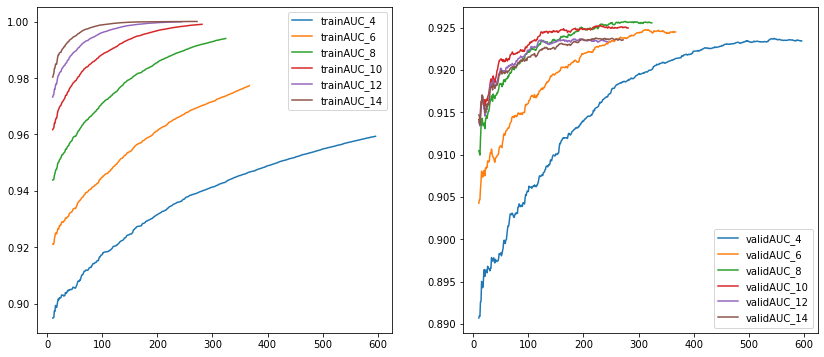

In [15]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(4,15,2)
# Sprawdzenie modelu dla różnych wartości hiperparametru:
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=x, early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Analizując powyższe wyniki wydaje się, że na początek optymalną głębokością drzewa jest 8. Nie dość, że uzyskujemy najlepszy wynik na zbiorze testowym, to przeuczenie nie jest tak ekstremalne jak przy głębszych drzewach.

### 4.2. Udział wierszy i kolumn.
W drugiej kolejności warto spojrzeć na `subsample`, a następnie `colsample_bytree`. Znów, trzeba zwrócić uwagę na fakt, iż dokonujemy jedynie zapoznania z modelem. Szukając najlepszych parametrów dla XGB musimy być świadomi, iż jest to wielowymiarowa przestrzeń, która zawiera liczne lokalne minima/maksima. Z tego powodu iteracyjna procedura nie gwarantuje optymalności wyniku (więcej o tym poniżej).

0.3 0.923347
0.4 0.923495
0.5 0.923308
0.6 0.924665
0.7 0.926138
0.8 0.926129
0.9 0.925617


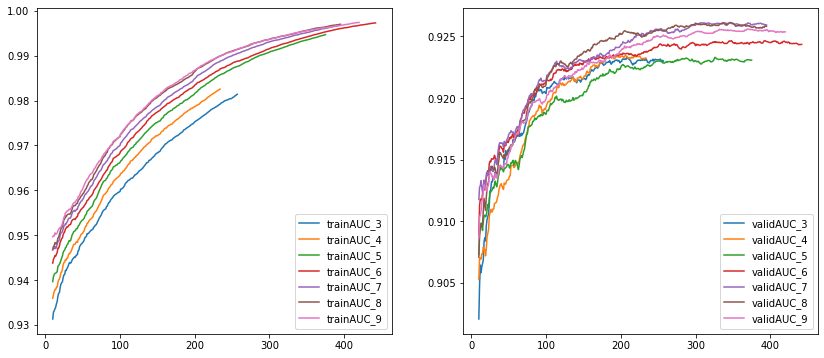

In [14]:
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=8,  subsample=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Wybieranie tylko części wierszy zdaje się nie wprowadzać dużych zmian. Nasz estymator jest bardzo stabilny pomiędzy różnymi wartościami hiperparametrów.

0.3 0.918898
0.4 0.922653
0.5 0.925517
0.6 0.925874
0.7 0.926138
0.8 0.925342
0.9 0.926153


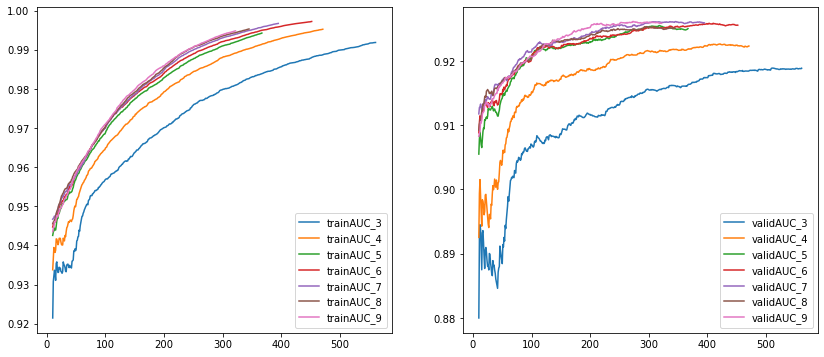

In [15]:
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=8, subsample=0.7, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

W przypadku części losowanych kolumn dochodzimy do podobnych wniosków jak w przypadku wierszy. W niektorych przypadkach warto również spojrzeć na `colsample_bylevel`, które można ustalać jednocześnie z `colsample_bytree` lub osobno (`colsample_bytree`=1).

3 0.925166
4 0.92479
5 0.924945
6 0.925586
7 0.925431
8 0.926264
9 0.92534
10 0.926138


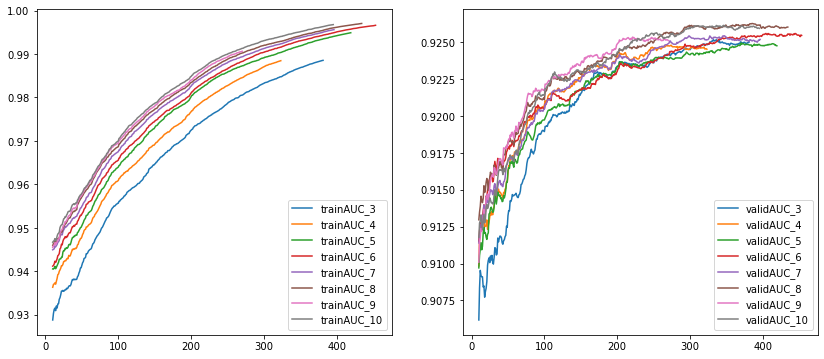

In [16]:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=8, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Z losowaniem wyłącznie per poziom:

3 0.923742
4 0.925248
5 0.926606
6 0.924752
7 0.927056
8 0.926507
9 0.924859
10 0.924817


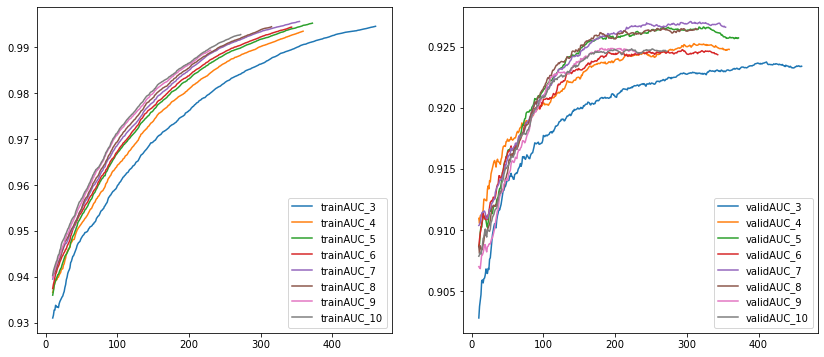

In [17]:
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=8, subsample=0.7, colsample_bytree=1, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Jak widać trudno powiedzieć, żebyśmy w ten sposób uzyskiwali zauważalnie lepsze wyniki. Możemy więc pozostać przy wartościach `subsample` i `colsample` na poziomie 0.7.

### 4.3. Regularyzacja L2
Skoro walka z przetrenowaniem jest jednym z najważniejszych elementów tuningu modeli wykorzystujących XGBoost. Warto pomyśleć o regularyzacji. Autorzy biblioteki zaimplementowali różne mechanizmy umożliwiające walkę z przetrenowaniem, ale najczęściej stosowana jest właśnie regularyzacja L2.

W przypadku XGB najlepszym pierwszym krokiem jest zwykle ustalenie odpowiedniego poziomu regularyzacji L2 (`lambda`). Wybierzemy więc w pierwszej iteracji wartości od 0 do 49 iterując x^2 od 0 do 7. Stosujemy takie podejście ze względu na to, iż w praktyce zakres optymalnych wartości dla `lambdy` jest bardzo szeroki. Jednocześnie model nie powinien być bardzo wrażliwy na względnie małe zmiany parametrów.

0 0.925294
1 0.926138
4 0.926553
9 0.926301
16 0.926929
25 0.926023
36 0.926168
49 0.92573


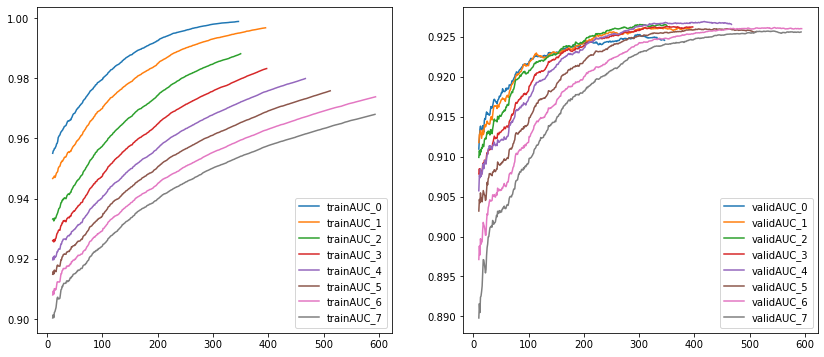

In [18]:
resHists = dict()

rang = range(0,8)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=x**2,
                                                          max_depth=8, subsample=0.7, colsample_bytree=0.7,
                                                          early_stopping_rounds=50, debug=False)
    
    print(x**2, score)
    resHists[x]=train_history
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Nasz zbiór danych wydaje się zachowywać bardzo stabilnie. Dla lambda pomiędzy 1 a 36 wyniki są praktycznie nierozróżnialne. Możemy zobaczyć, czy inne podejście będzie lepsze.

### 4.4 Parametr `gamma` - inny sposób na walkę z przetrenowaniem.
Na niektórych zbiorach dobranie odpowiedniej wielkości dla `gamma` pozwala na uzyskanie zdecydowanie lepszych rezultatów niż manipulacja `lambdą`. Warto zmniejszyć wielkość `lambda`, kiedy wprowadzamy dodatkową regularyzację. Parametr `gamma` jest podobny do parametru `min_impurity_decrease` w Random Forest. Parametr ten będzie wpływał na decyzję o tym, czy dokonać kolejnego splitu czy też nie w zależności od tego jak bardzo pomocne będzie jego wprowadzenie (czyli jak bardzo obniży się funkcja straty).

0 0.926929
0.01 0.92677
0.1 0.927145
0.5 0.926949
1 0.926379
2 0.926504
5 0.924768


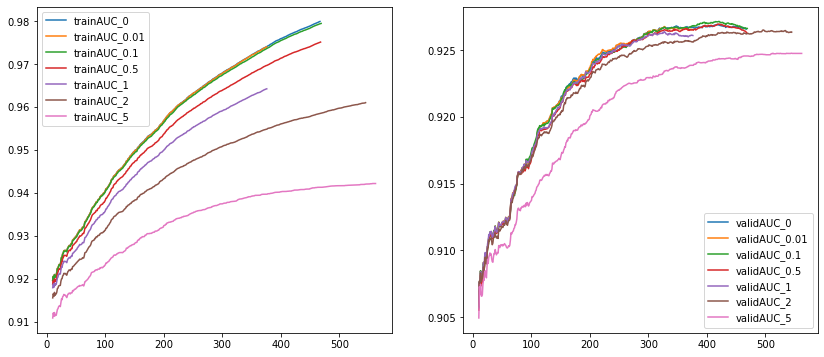

In [21]:
resHists = dict()
rang = [0, 0.01, 0.1, 0.5, 1, 2, 5]
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=16,
                                                          max_depth=8, subsample=0.7, colsample_bytree=0.7,
                                                          gamma=x, early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Zauważmy, że powyżej sprawdzamy parametr `gamma` dla dość wysokiej wartości `lambda` - oba parametry wpływają na algorytm w podobnym aspekcie (regularyzują model) więc jest ryzyko, że przez możliwą substytucyjność obydwu parametrów nie udaje się dobrze poznać możliwość `gamma` na tym zbiorze. Sprawdźmy działanie parametru dla lambda=0.

0 0.925294
0.01 0.925259
0.1 0.92469
0.5 0.924503
1 0.925258
2 0.926298
5 0.927226


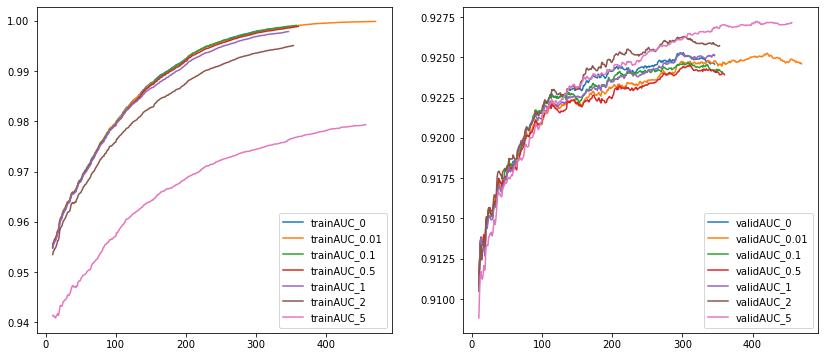

In [22]:
resHists = dict()
rang = [0, 0.01, 0.1, 0.5, 1, 2, 5]
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=0,
                                                          max_depth=8, subsample=0.7, colsample_bytree=0.7,
                                                          gamma=x, early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

Okazuje się, że `gamma` sprawdza się bardzo dobrze. Przeszukajmy dokładniej wartości 3-10:

1 0.925258
2 0.926298
3 0.925725
4 0.92613
5 0.927226
6 0.926914
7 0.927314
8 0.925941
9 0.926559
10 0.925827


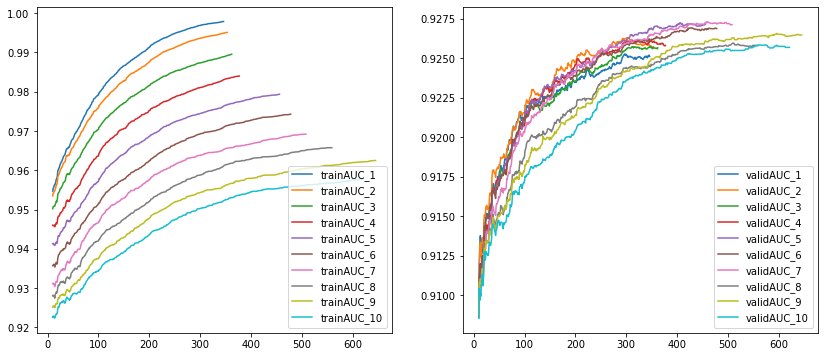

In [24]:
resHists = dict()
rang = list(range(1, 11))
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=0,
                                                          max_depth=8, subsample=0.7, colsample_bytree=0.7,
                                                          gamma=x,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()

## 5. Walidacja krzyżowa xgboost
Powyższe zabiegi to, jak wspomnieliśmy, tylko wstępna przymiarka. Kiedy ustalamy parametry na jednej realizacji podziału zbioru na treningowy i testowy niemal na pewno dokonujemy przetrenowania na poziomie hiperparametrów. Przygotujmy więc sobie wrapper który pozwoli nam łatwe testowanie parametrów z walidacją krzyżową. jako domyślne wartości wykorzystajmy nasze znalezione wcześniej wartosci. Postarajmy się aby wrapper dp walidacji krzyżowej był możliwie podobny do wcześniej używanych funkcji.

### 5.1 Pierwszy trening

In [17]:
# Przygotujmy prosty wrapper
def CVTestXGB(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

Ustawmy parametry które wybraliśmy i przeprowadźmy walidację modelu.

In [18]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
    max_depth=8, lambdaX=16, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

[20:05:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:05:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:05:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:05:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:05:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


(0.9764757832275794, 0.9271978430221035)

### 5.2 Znaczenie walidacji krzyżowej
Zobaczmy teraz jak różne wyniki osiągamy dla poszczególnych podzbiorów walidacyjnych. Na wykresie poniżej wyraźnie widać, że dla tak ustalonych parametrów obserwujemy bardzo wysokie zróżnicowanie wyników dla zbiorów walidacyjnych przy jednoczesnym wysokim podobieństwie zbiorów treningowych. Poniższy wykres dobitnie pokazuje znaczenie walidacji krzyżowej. Pamiętajmy, że ćwiczymy na zbiorze, który posiada 7 000 obserwacji.

Jednym z najistotniejszych wniosków z poniższego wykresu jest to, że dla różnych podzbiorów osiągamy najlepszy wynik dla diametralnie różnych liczb iteracji.To bardzo istotny wniosek z punktu widzenia wdrażania naszego rozwiązania do produkcji. Kiedy będziemy wdrażać model na produkcję najprawdopodobniej będziemy trenować na całym zbiorze i konieczne będzie ustalenie odpowiedniej liczby drzew. "Na szczęście", od pewnego momentu wszystkie krzywe na zbiorze walidacyjnym stają się relatywnie płaskie, co oznacza, że końcowy wynik nie będzie bardzo wrażliwy na małe zmiany w liczbie drzew.

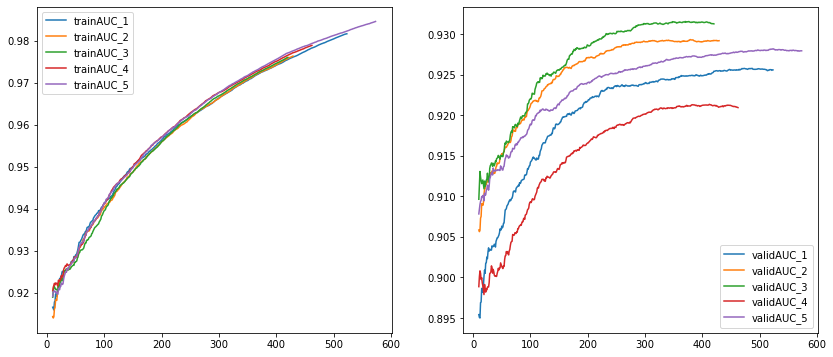

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for x in range(1,6):
    hists[['trainAUC'+'_'+str(x)]].iloc[10:].plot(ax=ax[0])
    hists[['validAUC'+'_'+str(x)]].iloc[10:].plot(ax=ax[1])
plt.show()

### 5.3 Ograniczenia walidacji krzyżowej
Musimy pamiętać, że nawet stosując walidację krzyżową (np. 5-fold CV), też dokonujemy lokalnego przetrenowania. Zobaczmy co się stanie jeżeli kilkukrotnie uruchomimy ten sam proces walidacji, z identycznymi parametrami, ale zmienimy tylko seed naszego losowania. Warto poniższy kod uruchomić kilkukrotnie i zobaczyć, że nawet przy średniej z 10 prób możemy osiągać różne wartości.

In [20]:
resList = []
for k in range(10):
    trainResults, testResults, predictions, indices, hists = CVTestXGB(randomState=randint(1,10000),
        max_depth=8, lambdaX=4, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False)
    resList.append(np.mean(testResults))
    print(np.mean(testResults), testResults)

[20:07:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9271743090846222 [0.9307545714488573, 0.9265518116652154, 0.9301887580791864, 0.9246258613373208, 0.9237505428925314]
[20:07:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9276808816608064 [0.926584364393743, 0.9259940077291609, 0.9189672735712812, 0.9333178954274853, 0.9335408671823616]
[20:07:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:07:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9269810827167604 [0.9347787307694161, 0.9195333217476378, 0.9229187327104755, 0.9246234166658568, 0.9330512116904156]
[20:08:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.927465861502695 [0.9365267853122969, 0.9250023727826547, 0.9223575208712018, 0.9271913894671568, 0.9262512390801649]
[20:08:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9282208562862024 [0.9321943518115766, 0.9121774598716925, 0.9275750317035367, 0.9351865911159637, 0.9339708469282422]
[20:08:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:08:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9272716367719642 [0.9348441356907959, 0.9256615357868405, 0.9235924771389793, 0.9311975077560463, 0.9210625274871592]
[20:09:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9274913080953879 [0.9241818855283924, 0.9176509976588015, 0.931864818021473, 0.9318214809916289, 0.9319373582766439]
[20:09:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9272161047859029 [0.9313198715997365, 0.9272926090005151, 0.9283855857919997, 0.9208111586770658, 0.9282712988601971]
[20:09:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:09:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:10:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9268202984735817 [0.9223598435462843, 0.9208636920497776, 0.9330138740678955, 0.9250582132935075, 0.9328058694104444]
[20:10:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:10:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:10:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:10:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:10:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9276266117678537 [0.9269046167542409, 0.93285775514037, 0.9221677174472465, 0.9280792953525167, 0.9281236741448943]


C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [21]:
print([round(x, 3) for x in resList])
print(np.mean(resList))

[0.927, 0.928, 0.927, 0.927, 0.928, 0.927, 0.927, 0.927, 0.927, 0.928]
0.9273948951145776


Jak widać nawet walidacja krzyżowa nie daje nam idealnego wyniku i odpowiedzi na pytanie jaka jest prawdziwa skuteczność danego zestawu parametrów. Wyniki są względnie stabilne, ale nie jest to pełna powtarzalność.

**WAŻNE!** Relatywnie duża zmienność wyników w walidacji krzyżowej zwykle wynika z tego, iż analizowany zbior danych jest względnie mały. Wraz ze wzrostem liczby obserwacji wzrastać będzie stabilność wyników.

### 5.4 Dobór hiperparametrów z walidacją krzyżową
Możemy teraz ponowić szybko nasz prosty iteracyjny proces dobierania hiperparametrów, tym razem korzystając z walidacji krzyżowej, aby zobaczyć czy osiągniemy inne wyniki niż poprzednio.

Ponownie rozpoczniemy od sprawdzenie wpływu głebokości drzew.

[20:11:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.9268267524962649
[20:11:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.927441741403384
[20:11:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:11:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.9273031876673192
[20:12:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 0.9279271029372561
[20:12:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.9271461034364281
[20:12:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:12:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.9269288379463434
[20:13:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


10 0.9263240572112984
[20:13:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20:13:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\pcwia\miniconda3\envs\ds\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


11 0.9267861765752643


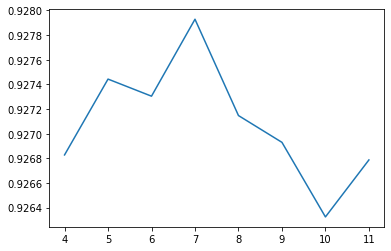

In [22]:
rang = range(4,12)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Jak widać wyniki są relatywnie stabilne. Różnica pomiedzy największym a najmniejszym wynikiem nie jest duża. Możemy uznać, że 7 to optymalna głębokość drzewa i przejść dalej do sprawdzania próbkowania wierszy i kolumn.

2 0.9230254664772428
3 0.9245585600226311
4 0.9254416061901217
5 0.9267395415748417
6 0.9269730750986019
7 0.9276580717480725
8 0.9279702539701826
9 0.9280053658900957


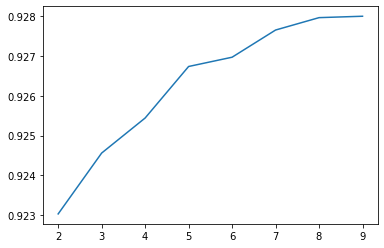

In [32]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=7, subsample = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

2 0.9204623344222025
3 0.9241547541921902
4 0.9264606786322366
5 0.927850938051154
6 0.9275521373428338
7 0.9279702539701826
8 0.9276411122920145
9 0.9271788559889735


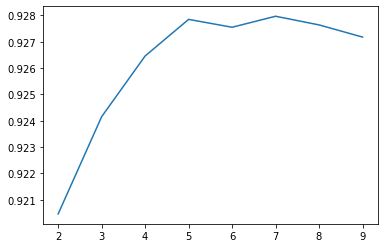

In [33]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=7, subsample = 0.8, colsample_bytree = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Nasz zbiór danych zdaje się podtrzymywać relatywnie nietypowe zachowanie, gdzie najlepsze wyniki uzyskuje przy małym próbkowaniu wierszy. Chociaż dla wartosci 0.9 uzyskaliśmy minimalnie lepszy wynik niż dla 0.8, to ta druga wartość wydaje się być bezpieczniejsza/lepsza. W większości przypadków będziemy starali się unikać skrajnych wartości tam gdzie to możliwe. Jeżeli zaś chodzi o próbkowanie, to tutaj o ile wyniki nie będą mocno sugerowały inaczej, będziemy wybierali wartości bardziej środkowe. W przypadku kolumn warto prawdopodobnie wybrać 0.7, chociaż różnica względem 0.5 jest pomijalna.

0 0.9272958155138239
1 0.9279702539701826
4 0.9272608091697057
9 0.9273187700260609
16 0.9276144544179242
25 0.9274039434385137
36 0.9273779034504914
49 0.9270716779484791


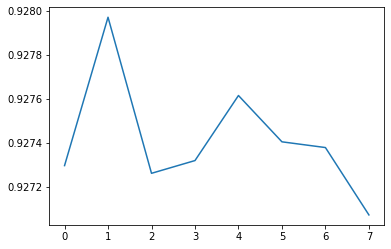

In [34]:
rang = range(0,8)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=x**2)
    print(x**2, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

0.01 0.9276752448476582
0.1 0.9277429587468002
0.5 0.9275257138290524
1 0.9278282695336235
2 0.9282356720660448
4 0.9284922642848178
6 0.9288955109094659
8 0.9278583873155835
10 0.9277299335088663
15 0.9250037467441281


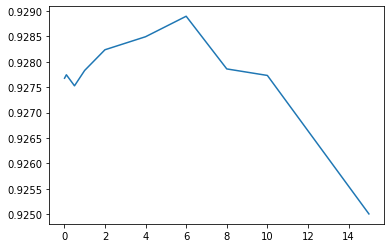

In [35]:
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()

Jak widać powrót do niemalże domyślnych parametrów i testowanie różnych wartości hiperparametrów w walidacji krzyżowej prowadzi nas do bardzo podobnych rezultatów jak w przypadku `lambda` pozwala na osiągnięcie niemalże identycznego wyniku. Tym razem prawdopodobnie wybierzemy minimalnie mniejszą wartość `lambda` i `gamma`. Niemniej jak spojrzymy na to w około jakich wyników zmienia się średnia metryka z wszystkich foldów należy uznać, że zmiany nie są duże.

Wydaje się to być dobrą wiadomością, która wskazuje na stabilność modelowania z użyciem XGB nawet dla szerokiego zakresu hiperparametrów.

### 5.5. Porównanie wyników

Przygotujmy sobie paczkę z wynikami modelu XGB i wczytajmy wczesniejsze wyniki.

In [36]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6)
print(np.mean(testResults))

modelXGB = {
    "name":"XGB",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=7, subsample = 0.8, colsample_bytree = 0.7, lambdaX=1, gamma=6',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.9288955109094659


In [37]:
# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_XGB_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelXGB, fp)

In [38]:
len(predictions)

5

In [39]:
# Wczytajmy też wcześniej zapisane modele
with open("model_ekonometria_1.p", "rb") as fp:
    modelEkonometria = pickle.load(fp)
    
with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)
    
with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)
    
with open("model_RF_1.p", "rb") as fp:
    modelRF = pickle.load(fp)

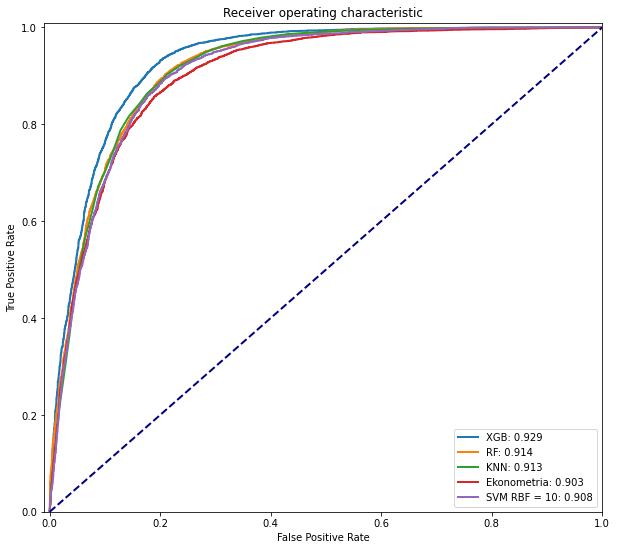

In [42]:
from helpers import plotROCs
res2plot = []
true = df[target].sort_index()
for result in [modelXGB, modelRF, modelkNN, modelEkonometria, modelSVM]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

### Krótkie podsumowanie
Analizując powyższe przykłady możemy wysnuć kilka wniosków:
* Proces walidacji krzyżowej jest niezwykle ważny aby uniknąć przetrenowania
* Na małych zbiorach danych powinniśmy wykazywać się szczególną ostrożnością w procesie optymalizacji hiperparametrów.
* Algorytm XGB jest relatywnie stabilny i nie charakteryzuje się silną wrażliwością na małe zmiany wartości parametrów.

## 6. Praktyczny poradnik tuningu XGB
* Rozpocznij pracę od oceny wartości poprawy funkcji celu. Jaką wartość biznesową ma dla mnie poprawa skuteczności predykcyjnej modelu o X? Jak kosztowny jest dla mnie czas poświęcony na tuning i rozwój modelu? W zdecydowanej większości przypadków nie uda nam się poprawić modelu bardzo znacząco w stosunku do najlepszego wyniku po 1000 iteracjach random search. Warto określić cele i planowany czas na początku prac.
* Sprawdź stabilność i wariancję wyników otrzymywanych w walidacji krzyżowej.
* Określ zakres sprawdzanych parametrów. Jeżeli nie ma znaczenia walka o dziesiętne/setne/tysięczne a czas jest cenny, warto ograniczyć się do niewielkiego zestawu parametrów. Jeżeli najmniejsze ułamki mają znaczenie, warto spojrzeć na wszystkie parametry łącznie i zaplanować więcej czasu oraz mocy obliczeniowej.
* Przejrzyj wartości pojedynczych hiperparametrów (wyświetlając wykresy uczenia się modeli na zbiorze treningowym i testowy). Ustal, które parametry są kluczowe, a które nie wpływają na wyniki.
* Używając walidacji krzyżowej ustal (brzegowo) interesujące przedziały hiperparametrów - w przypadku parametrów, które są w silnym związku (np. gamma i lambda) przetestuj przedziały dla różnych wariantów drugiego parametru. 
* Dla wybranych parametrów i relatywnie szerokich obszarów poszukiwań (na wszelki wypadek) przeprowadź grid lub random search. Kiedy moc obliczeniowa nie jest dla nas problemem możemy zdać się na gęsty grid search. Niektóre badania sugerują, że w większości przypadków najlepiej jest jednak wybrać random search (więcej na ten temat poniżej).
* Przeanalizuj wyniki pierwszych poszukiwań. Zmniejsz obszar przeszukiwań wybierając fragmenty o najwyższym potencjale. Ponów poszukiwania stosując wybraną metodę optymalizacji hiperparametrów na zawężonym obszarze (grid search, random search, bayesian optimization, hyperband, etc.).
* Jeżeli Twój zbiór danych jest niewielki warto przeprowadzać 3-10 krotną walidację dla jednego zestawu parametrów i wyciągnąć średnią (zob. pgraniczenia walidacji krzyżowej).
* Pamiętaj, że największą poprawę można zyskać zwykle dzięki inżynierii zmiennych, a nie nieskończonej precyzji w doborze parametrów.

Przypomnijmy, że podstawowe hiperparametry to:
```
--- Zmienne właściwe dla ensemble/boosting
eta : "learning rate"
max_depth=7 : maksymalna głębokość drzew [0,∞]
subsample : udział (0,1] obserwacji do treningu jednej iteracji
colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji

--- Zmienne regularyzacyjne
lambdaX : regularyzacja L2 [0,∞]
alpha=0 : regularyzacja L1 [0,∞]
gamma=1 : minimalna redukcja funkcji straty
min_child_weight : minimalna suma wg poddrzewa
```
W pierwszej kolejności koncentrujemy się zwykle na zmiennych właściwych dla ensemble/boostingu, gdyż w tym obszarze spodziewamy się największych zysków/zmian. Zmiennym dotyczącym regularyzacji powinniśmy się przyjrzeć w sytuacji, w której mamy do czynienia z silnym przetrenowaniem (duża, szybko rosnąca różnica pomiędzy ewaluacją dla zbioru treningowego i walidacyjnego).

## 7. Metody tuningu hiperparametrów.
Na pierwszy rzut oka *grid search* wydaje się być rozsądnym rozwiązaniem. W końcu w miarę równomiernie zmapujemy całą przestrzeń rozwiązań. W praktyce ze względu na to, że parametry wchodzą w nietypowe interakcje pomiędzy sobą, możemy obserwować współzależności ktore doprowadzą do sytuacji w której równomierny grid search spowoduje, że ominiemy całe interesujące nas regiony. Dobrze ten problem ilustruje poniższy obraz.
![title](img/randomGrid.png)
Źródło: Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. Journal of Machine Learning Research, 13(Feb), 281-305.

Losowanie kolejnych zestawów punktów do sprawdzenia ma jeszcze jedną zaletę. Kiedy stosujemy grid search zwykle ekspercko, czasem nieświadomie, określamy wiele parametrów (gęstość, zakresy, etc.). Może to doprowadzić do sytuacji w której w ogóle nie sprawdzimy części rozwiązań. Ludzki umysł ma bowiem silną tendencję do porządkowania i układania. Random search rozwiązuje ten problem i powoduje, że "uczciwiej" przeszukamy przestrzeń parametrów.

### Jak nie random search to co?
Nasuwa się więc pytanie kiedy nie powinniśmy stosować losowego przeszukiwania. Wydaje się, że najlepszym powodem może być czasochłonność trenowania algorytmu w optymalizowanym problemie. Odpowiednie metody pozwalają skrócić czas poszukiwania optymalnego rozwiązania o około połowę. Kiedy moc obliczeniowa jest kosztowna lub zależy nam na jak najszybszym znalezieniu najlepszych rozwiązań z powodów biznesowych może być warto przetestować inne rozwiązania.

Najpopularniejszym rozwiązaniem jest obecnie Bayesian optimization (które posiada wiele wariantów). Idea tego rozwiązania opiera się o adaptacyjnym zmniejszaniu wag dla tych fragmentów przeszukiwanej przestrzeni, które dają najmaniejszą wartość oczekiwaną. Skuteczność tego rozwiązania zależy od zastosowanej implementacji. W praktyce, jak widać na poniższym obrazku trudno liczyć na wzrost większy niż 50% w stosunku do random search.

![title](img/bayesRandom.png)
Źródło: Li, L., Jamieson, K., DeSalvo, G., Rostamizadeh, A., & Talwalkar, A. (2016). Hyperband: A novel bandit-based approach to hyperparameter optimization. arXiv preprint arXiv:1603.06560.

Inne podejście to algorytmu ewolucyjne. Obecnie nie cieszy się ono jednak zbyt dużą popularnością ze względu na fakt, iż nie gwarantuje poprawy efektywności względem random search, a jednoczesni istnieje ryzyko utknięcia w pewnym lokalnym minimum.

Lista alternatywnych podejść jest długa. Jednym z interesujących przykładów jest Hyperband, który nadaje się do algorytmów stosujących wiele iteracji i opiera się o założenie, że algorytmy najlepsze po n/2 iteracjach będą również najlepsze po n iteracjach. Drugi z obszaru globalnej optymalizacji opartej aproksymacje z wykorzystaniem funkcji Lipschitza (Malherbe, C., & Vayatis, N. (2017). Global optimization of Lipschitz functions. arXiv preprint arXiv:1703.02628.).

Każda z zaawansowanych metod wymaga jednak dodatkowego czasu potrzebnego na kodowanie i jednocześnie niesie ryzyko błędnej implementacji, o którą bardzo trudno w przypadku random search. Jeżeli jesteśmy w sytuacji, w której dwu-, trzykrotne skrócenie czasu tuningu oszczędzi nam tygodnie obliczeń to warto zainteresować się wspomnianymi powyżej metodami.

### Random search w praktyce
Podobnie jak wcześniej możemy sami zakodować algorytm, który na szerokich zakresach parametrów wykona tuning z użyciem random search. Możemy zobaczyć jak duży będzie rozstrzał wyników kiedy pozwolimy na naprawdę szeroki rozrzut.  Jednocześnie zobaczymy jak niewiele iteracji musimy wykonać, aby zbliżyć się relatywnie blisko maksymalnego wyniku.

In [43]:
import random
results=[]
paramList = []
for x in range(100):
    params = (random.randint(3, 9), random.uniform(0.3, 0.9), random.uniform(0.3, 0.9), random.uniform(0, 10), random.uniform(0, 10))
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3]**2,
        gamma=params[4])
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)

0.8667161075463351 (7, 0.4393346500539551, 0.10686342337701014, 5.1603272141660685, 4.6737209668319295)
0.9270426696286105 (9, 0.8504397133082874, 0.3525161286256784, 9.72955436164324, 6.170025832223772)
0.9271711716429045 (6, 0.8321595284933317, 0.581434361083543, 2.277464488354035, 8.73266680336722)
0.9235522728241271 (7, 0.36914379454065027, 0.8512755177070009, 6.7613423198486045, 7.658220852464655)
0.9233705427141334 (8, 0.31155824425085255, 0.6036380690979921, 8.893279151064187, 5.176262122932509)
0.9259097143095826 (7, 0.4343434685629006, 0.7916494500676803, 4.881156275855582, 6.714198889140811)
0.9255576005554044 (8, 0.43652836335365475, 0.5346360524060603, 7.329044687887598, 0.6053643620050375)
0.9237952298333468 (7, 0.23597459916276461, 0.5307718817095348, 2.776908130635886, 0.3116226773768671)
0.9250188577290632 (9, 0.4413959927758144, 0.4429828966206838, 6.737524979433937, 1.21806220086089)
0.9212798033928233 (9, 0.3186552305512975, 0.4862607195242392, 6.7992710026437555, 7.

0.9061044619600311 (3, 0.1539553393514037, 0.7686493286690883, 2.0242693874899587, 8.831625684207738)
0.9210940462594749 (3, 0.5617706820789455, 0.3973292124188983, 8.47755974274735, 1.229926502927482)
0.9227088109506798 (4, 0.8111697067307816, 0.76242975187551, 6.242995261865803, 9.250592442867283)
0.919979983541975 (3, 0.3838947473346431, 0.5793332416427694, 8.3135614765797, 4.269685809438846)
0.9278690028723153 (6, 0.588811502562435, 0.6449824103600472, 2.0433627596271178, 6.712152053223828)
0.9282464968097621 (9, 0.7654647267355364, 0.49934906315521865, 5.653709941114668, 2.6215956558848372)
0.923615004726613 (9, 0.8034256912618759, 0.18791200825536658, 0.06598889685611176, 8.80741487332009)
0.9269835505868926 (8, 0.80609811397038, 0.33037509656808406, 0.24010665408444987, 8.619165617754689)
0.9097893664731522 (9, 0.26623593914943844, 0.2655649281121105, 7.39672524180822, 9.521014151552563)
0.9211059237003285 (8, 0.14485361080563175, 0.4492233792118121, 3.799873562012417, 1.2823374

Możemy zobaczyć najlepsze wyniki i ocenić jak mocno się od siebie różnią.

In [44]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(0.9282464968097621, (9, 0.7654647267355364, 0.49934906315521865, 5.653709941114668, 2.6215956558848372))
(0.9282455511145423, (9, 0.740841565675769, 0.45611659879616395, 2.581351087617886, 3.3099281286019377))
(0.92800148454064, (6, 0.8479985844517038, 0.40411348680886083, 7.209539812571143, 3.3778155827600242))
(0.927982816200233, (9, 0.7677518541661741, 0.46277141929404264, 9.111939347368748, 3.594941469718905))
(0.9279382203466945, (9, 0.512519407223315, 0.7177981042827078, 2.0722156107894385, 6.805023291877862))
(0.9278690028723153, (6, 0.588811502562435, 0.6449824103600472, 2.0433627596271178, 6.712152053223828))
(0.9277698379990286, (9, 0.5026897018038795, 0.6671988867304687, 4.144410810378974, 4.537337532565684))
(0.927763031291945, (6, 0.7631652264165036, 0.7148797520048538, 5.661986744165506, 4.835047643108052))
(0.9276961991148702, (8, 0.47619409498512044, 0.5810632204582382, 0.9642690399709519, 7.046818428870203))
(0.9276450417293371, (8, 0.7181115930047938, 0.5061271749635

Poniższy wykres pokazuje najlepszy rezultat po danej iteracji. Jak widać krańcowe korzyści ze zwiększania liczby prób maleją bardzo szybko. Co więcej uzyskaliśmy w zasadzie tak samo dobry wynik jak wcześniejszą prostą metodą iteracyjną.

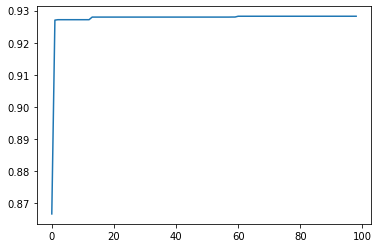

In [45]:
plt.plot(list(range(len(results)-1)), maxRes)
plt.show()